In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import os
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

In [2]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]   
    
    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image



In [3]:
def load_data(dir_list, image_size):
   

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [4]:
augmented_path = "C:/Users/SuperAdmin/Desktop/Jupi - MBT/C1datasets/"

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (128, 128)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 800
X shape is: (800, 128, 128, 3)
y shape is: (800, 1)


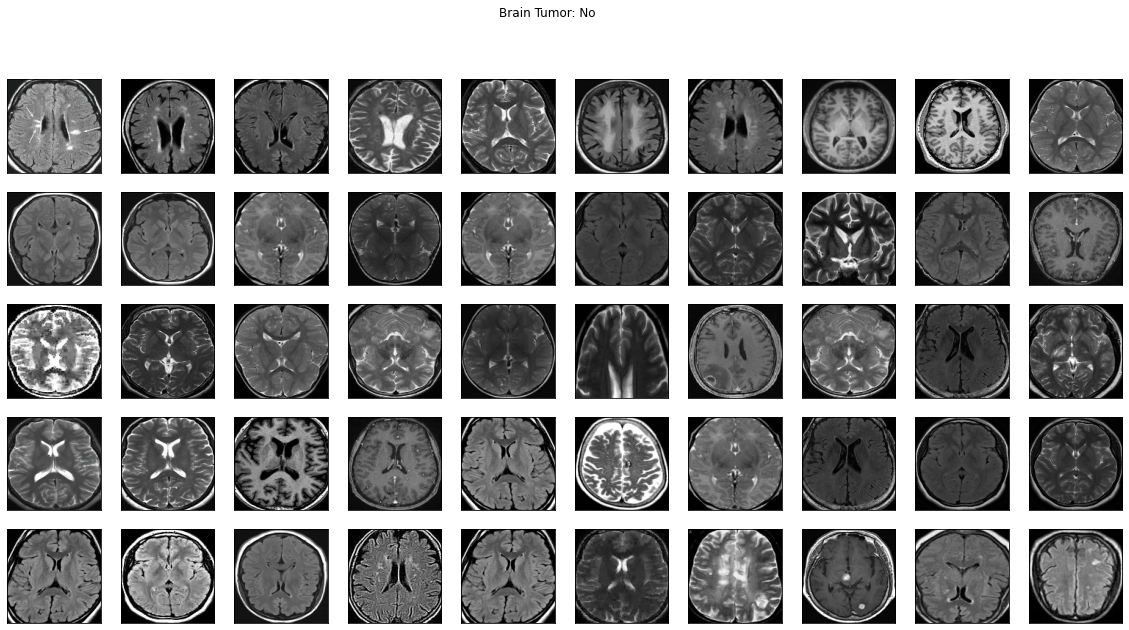

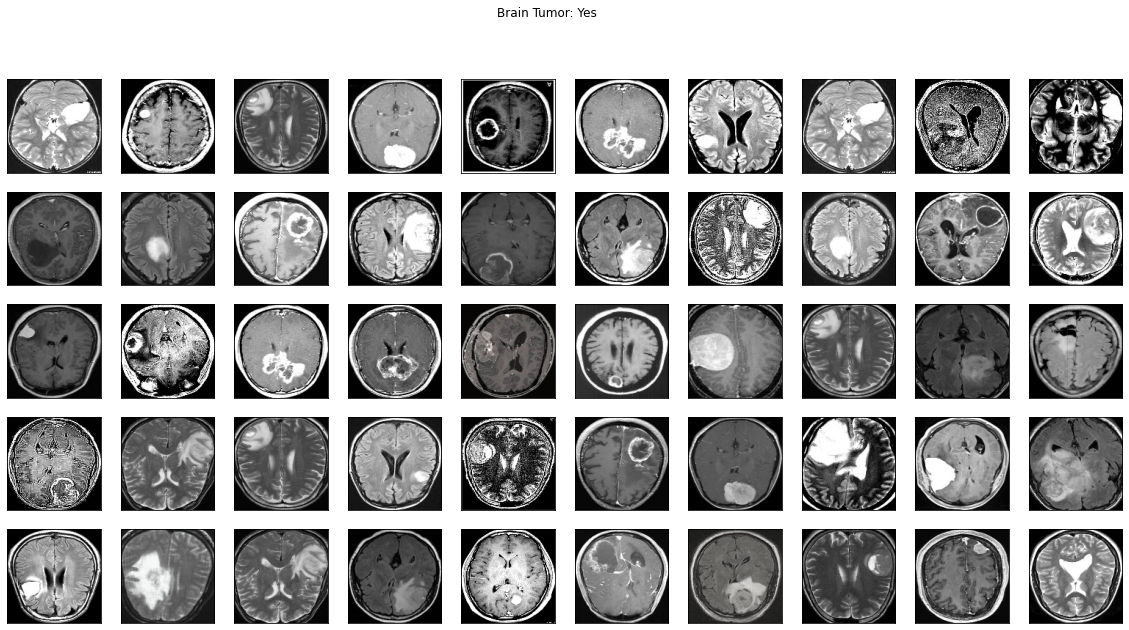

In [5]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()
plot_sample_images(X, y)

In [6]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test


X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 560
number of development examples = 120
number of test examples = 120
X_train shape: (560, 128, 128, 3)
Y_train shape: (560, 1)
X_val (dev) shape: (120, 128, 128, 3)
Y_val (dev) shape: (120, 1)
X_test shape: (120, 128, 128, 3)
Y_test shape: (120, 1)


In [7]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [16]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, Reshape, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score

# Create a Sequential model
model = Sequential()

# Add a convolutional layer with 32 filters of size 2x2 and 'same' padding
# Input shape is (128, 128, 3)
model.add(Conv2D(32, (2, 2), padding='same', input_shape=(128, 128, 3)))
model.add(Activation('relu'))

# Add another convolutional layer with 32 filters of size 2x2
model.add(Conv2D(32, (2, 2)))
model.add(Activation('relu'))

# Add a max pooling layer with pool size 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a dropout layer with a rate of 0.2
model.add(Dropout(0.2))

# Add a convolutional layer with 128 filters of size 2x2 and 'same' padding
model.add(Conv2D(128, (2, 2), padding='same'))
model.add(Activation('relu'))

# Add another convolutional layer with 64 filters of size 3x3
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

# Add a max pooling layer with pool size 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a dropout layer with a rate of 0.25
model.add(Dropout(0.25))

# Flatten the output from previous layers
model.add(Flatten())

# Reshape the flattened output to have shape (1, -1)
model.add(Reshape((1, -1)))

# Define the number of timesteps and features
timesteps = 1
features = 128 * 128 * 3

# Add a dropout layer with a rate of 0.25
model.add(Dropout(0.25))

# Add an LSTM layer with 120 units, using the defined timesteps and features
model.add(LSTM(units=120, input_shape=(timesteps, features), activation='relu'))

# Add a fully connected dense layer with 128 units and ReLU activation
model.add(Dense(128))
model.add(Activation('relu'))

# Add a dropout layer with a rate of 0.5
model.add(Dropout(0.5))

# Add another fully connected dense layer with 64 units and ReLU activation
model.add(Dense(64))
model.add(Activation('relu'))

# Add the final dense layer with 2 units and softmax activation for classification
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 32)      416       
                                                                 
 activation_18 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 127, 127, 32)      4128      
                                                                 
 activation_19 (Activation)  (None, 127, 127, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 63, 63, 32)        0         
                                                      

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# tensorboard
log_file_name = f'brain_tumor_detection_cnnhbd_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="Classification1hbd.h5"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("cc1hbd.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [18]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/20
18/18 [==============================] - ETA: 0s - loss: 0.6608 - accuracy: 0.5464

INFO:tensorflow:Assets written to: cc1hbd.model\assets


INFO:tensorflow:Assets written to: cc1hbd.model\assets


18/18 [==============================] - 53s 3s/step - loss: 0.6608 - accuracy: 0.5464 - val_loss: 0.6709 - val_accuracy: 0.7667
Epoch 2/20
18/18 [==============================] - ETA: 0s - loss: 0.6255 - accuracy: 0.6732

INFO:tensorflow:Assets written to: cc1hbd.model\assets


INFO:tensorflow:Assets written to: cc1hbd.model\assets


18/18 [==============================] - 43s 2s/step - loss: 0.6255 - accuracy: 0.6732 - val_loss: 0.5568 - val_accuracy: 0.6917
Epoch 3/20
18/18 [==============================] - ETA: 0s - loss: 0.4599 - accuracy: 0.8250

INFO:tensorflow:Assets written to: cc1hbd.model\assets


INFO:tensorflow:Assets written to: cc1hbd.model\assets


18/18 [==============================] - 43s 2s/step - loss: 0.4599 - accuracy: 0.8250 - val_loss: 0.3886 - val_accuracy: 0.9167
Epoch 4/20
18/18 [==============================] - ETA: 0s - loss: 0.3118 - accuracy: 0.8714

INFO:tensorflow:Assets written to: cc1hbd.model\assets


INFO:tensorflow:Assets written to: cc1hbd.model\assets


18/18 [==============================] - 43s 2s/step - loss: 0.3118 - accuracy: 0.8714 - val_loss: 0.1890 - val_accuracy: 0.9417
Epoch 5/20
18/18 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 0.9179

INFO:tensorflow:Assets written to: cc1hbd.model\assets


INFO:tensorflow:Assets written to: cc1hbd.model\assets


18/18 [==============================] - 43s 2s/step - loss: 0.2067 - accuracy: 0.9179 - val_loss: 0.2049 - val_accuracy: 0.9167
Epoch 6/20
18/18 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.9268

INFO:tensorflow:Assets written to: cc1hbd.model\assets


INFO:tensorflow:Assets written to: cc1hbd.model\assets


18/18 [==============================] - 43s 2s/step - loss: 0.1767 - accuracy: 0.9268 - val_loss: 0.0870 - val_accuracy: 0.9667
Epoch 7/20
18/18 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.9696

INFO:tensorflow:Assets written to: cc1hbd.model\assets


INFO:tensorflow:Assets written to: cc1hbd.model\assets


18/18 [==============================] - 43s 2s/step - loss: 0.0920 - accuracy: 0.9696 - val_loss: 0.4193 - val_accuracy: 0.8667
Epoch 8/20
18/18 [==============================] - ETA: 0s - loss: 0.1454 - accuracy: 0.9571

INFO:tensorflow:Assets written to: cc1hbd.model\assets


INFO:tensorflow:Assets written to: cc1hbd.model\assets


18/18 [==============================] - 43s 2s/step - loss: 0.1454 - accuracy: 0.9571 - val_loss: 0.1397 - val_accuracy: 0.9417
Epoch 9/20
18/18 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.9714

INFO:tensorflow:Assets written to: cc1hbd.model\assets


INFO:tensorflow:Assets written to: cc1hbd.model\assets


18/18 [==============================] - 42s 2s/step - loss: 0.0860 - accuracy: 0.9714 - val_loss: 0.1020 - val_accuracy: 0.9833
Epoch 10/20
18/18 [==============================] - ETA: 0s - loss: 0.0459 - accuracy: 0.9839

INFO:tensorflow:Assets written to: cc1hbd.model\assets


INFO:tensorflow:Assets written to: cc1hbd.model\assets


18/18 [==============================] - 43s 2s/step - loss: 0.0459 - accuracy: 0.9839 - val_loss: 0.2976 - val_accuracy: 0.9583
Epoch 11/20
18/18 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9929

INFO:tensorflow:Assets written to: cc1hbd.model\assets


INFO:tensorflow:Assets written to: cc1hbd.model\assets


18/18 [==============================] - 43s 2s/step - loss: 0.0141 - accuracy: 0.9929 - val_loss: 0.2662 - val_accuracy: 0.9417
Epoch 12/20
18/18 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9929

INFO:tensorflow:Assets written to: cc1hbd.model\assets


INFO:tensorflow:Assets written to: cc1hbd.model\assets


18/18 [==============================] - 43s 2s/step - loss: 0.0193 - accuracy: 0.9929 - val_loss: 0.3899 - val_accuracy: 0.9583
Epoch 13/20
18/18 [==============================] - ETA: 0s - loss: 0.0527 - accuracy: 0.9875

INFO:tensorflow:Assets written to: cc1hbd.model\assets


INFO:tensorflow:Assets written to: cc1hbd.model\assets


18/18 [==============================] - 43s 2s/step - loss: 0.0527 - accuracy: 0.9875 - val_loss: 0.1751 - val_accuracy: 0.9667
Epoch 14/20
18/18 [==============================] - ETA: 0s - loss: 0.0782 - accuracy: 0.9750

INFO:tensorflow:Assets written to: cc1hbd.model\assets


INFO:tensorflow:Assets written to: cc1hbd.model\assets


18/18 [==============================] - 43s 2s/step - loss: 0.0782 - accuracy: 0.9750 - val_loss: 0.1287 - val_accuracy: 0.9500
Epoch 15/20
18/18 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 0.9893

INFO:tensorflow:Assets written to: cc1hbd.model\assets


INFO:tensorflow:Assets written to: cc1hbd.model\assets


18/18 [==============================] - 43s 2s/step - loss: 0.0414 - accuracy: 0.9893 - val_loss: 0.0867 - val_accuracy: 0.9750
Epoch 16/20
18/18 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 1.0000

INFO:tensorflow:Assets written to: cc1hbd.model\assets


INFO:tensorflow:Assets written to: cc1hbd.model\assets


18/18 [==============================] - 42s 2s/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.1482 - val_accuracy: 0.9750
Epoch 17/20
18/18 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.9982

INFO:tensorflow:Assets written to: cc1hbd.model\assets


INFO:tensorflow:Assets written to: cc1hbd.model\assets


18/18 [==============================] - 42s 2s/step - loss: 0.0022 - accuracy: 0.9982 - val_loss: 0.1675 - val_accuracy: 0.9750
Epoch 18/20
18/18 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9982

INFO:tensorflow:Assets written to: cc1hbd.model\assets


INFO:tensorflow:Assets written to: cc1hbd.model\assets


18/18 [==============================] - 43s 2s/step - loss: 0.0043 - accuracy: 0.9982 - val_loss: 0.2095 - val_accuracy: 0.9667
Epoch 19/20
18/18 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

INFO:tensorflow:Assets written to: cc1hbd.model\assets


INFO:tensorflow:Assets written to: cc1hbd.model\assets


18/18 [==============================] - 43s 2s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1740 - val_accuracy: 0.9667
Epoch 20/20
18/18 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9982

INFO:tensorflow:Assets written to: cc1hbd.model\assets


INFO:tensorflow:Assets written to: cc1hbd.model\assets


18/18 [==============================] - 43s 2s/step - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0.1874 - val_accuracy: 0.9667
Elapsed time: 0:14:28.3


In [19]:
history = model.history.history
for key in history.keys():
    print(key)
    
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
f1score = compute_f1_score(y_test, y_pred)
print(f"F1 score: {f1score}")

loss
accuracy
val_loss
val_accuracy
4/4 [==============================] - 2s 321ms/step
F1 score: 0.9375


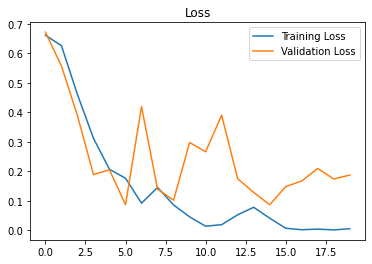

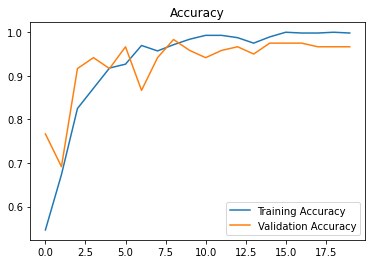

In [20]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
plot_metrics(history) 

In [22]:
from keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [23]:
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
import gc
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-23-947da88f9dbb>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


In [24]:
Y_pred = model.predict(X_test)
Y_test_pred = model.predict(X_test)

4/4 [==============================] - 1s 345ms/step


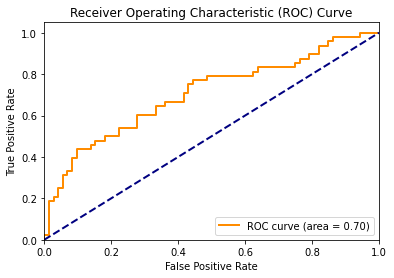

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have y_true (true binary labels) and y_scores (predicted probabilities for positive class)

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, Y_pred_tta)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()